In [1]:
!pip install torch torchvision torchaudio

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os


In [5]:
data_dir = r"C:\Users\Gayatri\Downloads\archive"   # change to your dataset folder

# ---- DATA TRANSFORM ----
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [7]:
# ---- LOAD DATA ----
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_data  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Classes: {train_data.classes}")


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [9]:
# ---- MODEL ----
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [11]:
# ---- SETUP ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = EmotionCNN(num_classes=len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cpu


In [13]:
# ---- TRAIN ----
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10] | Loss: 1.6308
Epoch [2/10] | Loss: 1.3632
Epoch [3/10] | Loss: 1.2335
Epoch [4/10] | Loss: 1.1367
Epoch [5/10] | Loss: 1.0510
Epoch [6/10] | Loss: 0.9657
Epoch [7/10] | Loss: 0.8769
Epoch [8/10] | Loss: 0.7846
Epoch [9/10] | Loss: 0.7095
Epoch [10/10] | Loss: 0.6268


In [15]:
# ---- EVALUATE ----
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images).argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 58.26%


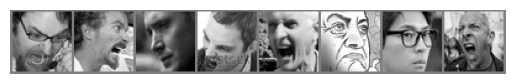

Predicted: ['happy', 'angry', 'sad', 'angry', 'angry', 'fear', 'neutral', 'angry']
Actual:    ['angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry']


In [19]:
# ---- VISUALIZE ----
import torchvision

def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images[:8]))

outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

print("Predicted:", [train_data.classes[p] for p in preds[:8]])
print("Actual:   ", [train_data.classes[l] for l in labels[:8]])